# Proyecto: Descifrando Mensajes Codificados Usando MCMC

Integrantes: Sebastián Flores y Matías Neto

## Procesamiento de la fuente de texto

In [1]:
%pip install pycipher

You should consider upgrading via the '/home/sflores/anaconda3/bin/python -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [2]:
import re
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pycipher import SimpleSubstitution


In [3]:
# Cargar el texto
with open("gloria_benitoperezgaldos.txt", "r") as f:
    text = f.readlines()

for i in range(len(text)):
    text[i] = text[i].replace('\n', '')

text = ' '.join(text)

In [4]:
# Sólo minúsculas
clean_text = text.casefold()

# Eliminar tildes
tilde_dict = {'á':'a', 'é': 'e', 'í': 'i', 'ó':'o', 'ú':'u', 'ñ': 'n'}
for key, value in tilde_dict.items():
    clean_text = clean_text.replace(key, value)

# Eliminar caracteres especiales
clean_text = re.sub(r"[^a-zA-Z ]", "", clean_text)
clean_text = clean_text.upper()

In [5]:
def process(word, matrix):
    '''
    Almacena la frecuencia de transiciones de una palabra en una matriz
    
    Argumentos:
        word (string): Palabra a procesar
        matrix (pd.DataFrame): Matriz de transición
    
    Retorna:
        matrix (pd.DataFrame): Matriz de transición actualizada con
                               la palabra procesada
    '''
    letters = list(word)
    matrix.loc[' ', letters[0]] = matrix.loc[' ', letters[0]] + 1
    for i in range(len(word)-1):
        matrix.loc[letters[i], letters[i+1]] = matrix.loc[letters[i], letters[i+1]] + 1
    matrix.loc[letters[len(word)-1], ' '] = matrix.loc[letters[len(word)-1], ' '] + 1
    return matrix

In [6]:
# Creación de la matriz
alphabet = sorted(''.join(set(clean_text)))
matrix = pd.DataFrame(data=np.zeros((len(alphabet), len(alphabet))), index=alphabet, columns=alphabet)
words = clean_text.split()

# Se demora unos minutos
for word in words:
    matrix = process(word, matrix)
transition = matrix.apply(lambda x: x/np.sum(x), axis=1)

### Matriz para ataque de trigrama

In [7]:
def trig_process(word, matrix):
    '''
    Almacena la frecuencia de transiciones de una palabra en una matriz
    
    Argumentos:
        word (string): Palabra a procesar
        matrix (pd.DataFrame): Matriz de transición
    
    Retorna:
        matrix (pd.DataFrame): Matriz de transición actualizada con
                               la palabra procesada
    '''
    letters = list(word)
    if len(word) == 1:
        matrix.loc[' ' + letters[0], ' '] = matrix.loc[' ' + letters[0], ' '] + 1
    else:
        matrix.loc[' ' + letters[0], letters[1]] = matrix.loc[' ' + letters[0], letters[1]] + 1
        for i in range(len(word)-2):
            matrix.loc[letters[i] + letters[i+1], letters[i+2]] = matrix.loc[letters[i] + letters[i+1], letters[i+2]] + 1
        matrix.loc[letters[-2] + letters[-1], ' '] = matrix.loc[letters[-2] + letters[-1], ' '] + 1
    return matrix

trig_index = [f + s for f in list(alphabet) for s in list(alphabet[1:])]
trig_columns = alphabet
trig_matrix = pd.DataFrame(data=np.zeros((len(trig_index), len(trig_columns))), index=trig_index, columns=trig_columns)

for word in words:
    trig_matrix = trig_process(word, trig_matrix)
trig_transition = trig_matrix.apply(lambda x: x/np.sum(x), axis=1)

## Definición de funciones auxiliares para la minimización

In [8]:
def plausibility(ciphertext, key, matrix = transition):
    '''
    Función de plausibilidad que tiene el rol de -U para SA
    
    Argumentos:
        ciphertext (string): Texto codificado
        key (string): Clave del mismo largo que el alfabeto a testear
        matrix (pd.DataFrame): Matriz de transición construida antes
    
    Retorna:
        plausibility (float): valor de la plausibilidad para key
    '''
    cipher = SimpleSubstitution(key)
    plaintext = cipher.decipher(ciphertext, keep_punct = True)
    words = plaintext.split()
    matrix = pd.DataFrame(data=np.zeros((len(alphabet), len(alphabet))), index=alphabet, columns=alphabet)
    for word in words:
        matrix = process(word, matrix)
    plausibility = np.sum((1 + matrix.to_numpy()) * np.log(1 + transition.to_numpy()))
    return plausibility

# Ejemplo
plaintext = "MUCHOS ANOS DESPUES FRENTE AL PELOTON DE FUSILAMIENTO " + \
            "EL CORONEL AURELIANO BUENDIA RECORDO AQUELLA TARDE REMOTA " + \
            "EN QUE SU PADRE LO LLEVO A CONOCER EL HIELO"
real_key = "AJPCZWRLFBDKOTYUQGENHXMIVS"
real_cipher = SimpleSubstitution(real_key)
ciphertext = real_cipher.encipher(plaintext, keep_punct = True)
print(f"Texto cifrado: {ciphertext}")
print(f"Plausibilidad: {plausibility(ciphertext, real_key)}")

Texto cifrado: OHPLYE ATYE CZEUHZE WGZTNZ AK UZKYNYT CZ WHEFKAOFZTNY ZK PYGYTZK AHGZKFATY JHZTCFA GZPYGCY AQHZKKA NAGCZ GZOYNA ZT QHZ EH UACGZ KY KKZXY A PYTYPZG ZK LFZKY
Plausibilidad: 47.44776747911044


In [17]:
# Ejemplo para ver que efectivamente la plausibilidad es menor
example_key = ''.join(random.sample(real_key, len(real_key)))
print("Clave ejemplo: " + example_key)
example_cipher = SimpleSubstitution(example_key)
print("Texto descifrado con la clave: "+example_cipher.decipher(ciphertext, keep_punct=True))
print(f"Plausibilidad: {plausibility(ciphertext, example_key)}")

Clave ejemplo: AYJRZDHLSBTONUIWCMFPEKQVGX
Texto descifrado con la clave: LGTHBU AKBU QEUNGEU PYEKME AV NEVBMBK QE PGUSVALSEKMB EV TBYBKEV AGYEVSAKB CGEKQSA YETBYQB AWGEVVA MAYQE YELBMA EK WGE UG NAQYE VB VVEZB A TBKBTEY EV HSEVB
Plausibilidad: 33.67836433747776


In [18]:
def neighbor(key):
    '''
    Retorna un vecino aleatorio (con distribución uniforme) de la clave
    
    Argumentos:
        key (str): Clave representada por una permutación del alfabeto
    
    Retorna:
        new_key (str): Clave vecina a key
    '''
    indices = random.sample(list(np.arange(len(key))), 2)
    symbol_a, symbol_b = key[indices[0]], key[indices[1]]
    new_key = list(key)
    new_key[indices[0]] = symbol_b
    new_key[indices[1]] = symbol_a
    new_key = ''.join(new_key)
    return new_key

nghbr = neighbor(example_key)
print(f"Clave ejemplo: {example_key}")
print(f"Vecino: {nghbr}")
print(f"Indices intercambiados: {[i for i in range(len(example_key)) if example_key[i] != nghbr[i]]}")

Clave ejemplo: AYJRZDHLSBTONUIWCMFPEKQVGX
Vecino: AYJRGDHLSBTONUIWCMFPEKQVZX
Indices intercambiados: [4, 24]


In [31]:
def accuracy(plaintext: str, ciphertext:str, key: str):
    '''
    Calcula la precisión de guess respecto de plaintext.
    Es la distancia de Shannon normalizada
    '''
    assert len(plaintext) == len(ciphertext)
    cipher = SimpleSubstitution(key)
    guess = cipher.decipher(ciphertext, keep_punct = True)
    aciertos = [1 for i in range(len(plaintext)) if (plaintext[i] == guess[i]) and plaintext[i] != ' ']
    return sum(aciertos)/len(plaintext)

## Optimización

In [32]:
def SADecipher(ciphertext: str, Niter: int, beta, plaintext,
               initial_key = random.sample(alphabet[1:], len(alphabet) - 1),
               print_period = None):
    '''
    Función que implementa Simmulated Annealing 
    para el problema de descifrado
    
    Argumentos:
        ciphertext: Código a descifrar
        Niter: Número de pasos a realizar
        beta (fun): Función que representa el beta del método de SA
        initial_key (str): una clave inicial para el algoritmo
        print_period: Representa el periodo de actualización. 
            Si no es None, se imprime el estado de la cadena
            y la plausibilidad cada print_period pasos
    
    Retorna:
        key: Estado de la cadena luego de Niter pasos
    '''
    
    U = np.random.uniform(0, 1, size = Niter)
    key = initial_key
    incumbent_plaus = plausibility(ciphertext, key)
    incumbent_accuracy = accuracy(plaintext, ciphertext, key)
    scores = np.zeros(Niter)
    accuracies = np.zeros(Niter)
    if print_period == None:
        for i in range(Niter):
            scores[i] = incumbent_plaus
            accuracies[i] = incumbent_accuracy
            new_key = neighbor(key)
            new_plaus = plausibility(ciphertext, new_key)
            if U[i] <= np.exp(beta(i) * (new_plaus - incumbent_plaus)):
                key = new_key
                incumbent_plaus = new_plaus
                incumbent_accuracy = accuracy(plaintext, ciphertext, key)

    else:
        for i in range(Niter):
            scores[i] = incumbent_plaus
            accuracies[i] = incumbent_accuracy
            new_key = neighbor(key)
            new_plaus = plausibility(ciphertext, new_key)
            if U[i] <= np.exp(beta(i) * (new_plaus - incumbent_plaus)):
                key = new_key
                incumbent_plaus = new_plaus
                incumbent_accuracy = accuracy(plaintext, ciphertext, key)
            if i % print_period == 0:
                cipher = SimpleSubstitution(key)
                print(f"Paso {i}")
                print(f"Frase actual: {cipher.decipher(ciphertext, keep_punct = True)}")
                print(f"Plausibilidad: {incumbent_plaus}")
    return key, scores, accuracies

# Test de SADecipher
beta = lambda x: 1     
sample_advance, sample_scores, sample_accuracies = SADecipher(ciphertext, 10, beta, plaintext)
print(f"Estado de la cadena luego de 10 pasos con beta = 1: {sample_advance}")
print(f"Indices intercambiados: {[i for i in range(len(example_key)) if 'ABCDEFGHIJKLMNOPQRSTUVWXYZ'[i] != sample_advance[i]]}")

Estado de la cadena luego de 10 pasos con beta = 1: XVTEHPUWKQCZSALRMNOBJIGFYD
Indices intercambiados: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 25]


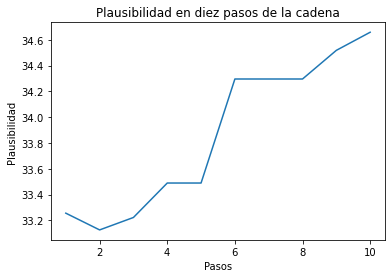

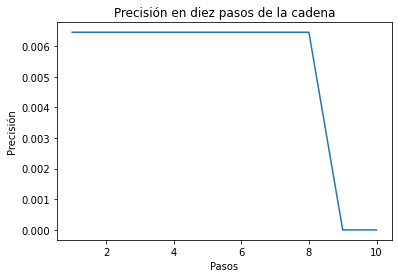

In [33]:
def graph_scores(scores, Niter, title):
    plt.figure()
    plt.plot(np.arange(Niter) + 1, scores)
    plt.title(title)
    plt.xlabel("Pasos")
    plt.ylabel("Plausibilidad")
    plt.show()
    return 

def graph_accuracies(accuracies, Niter, title):
    plt.figure()
    plt.plot(np.arange(Niter) + 1, accuracies)
    plt.title(title)
    plt.xlabel("Pasos")
    plt.ylabel("Precisión")
    plt.show()
graph_scores(sample_scores, 10, "Plausibilidad en diez pasos de la cadena")
graph_accuracies(sample_accuracies, 10, "Precisión en diez pasos de la cadena")

Paso 0
Frase actual: NEFOYX ZIYX KLXHELX GWLIRL ZC HLCYRYI KL GEXSCZNSLIRY LC FYWYILC ZEWLCSZIY BELIKSZ WLFYWKY ZJELCCZ RZWKL WLNYRZ LI JEL XE HZKWL CY CCLAY Z FYIYFLW LC OSLCY
Plausibilidad: 32.71242708517882
Paso 1000
Frase actual: JZRUAG YDAG TOGKZOG WMODFO YH KOHAFAD TO WZGIHYJIODFA OH RAMADOH YZMOHIYDA CZODTIY MORAMTA YPZOHHY FYMTO MOJAFY OD PZO GZ KYTMO HA HHONA Y RADAROM OH UIOHA
Plausibilidad: 38.97882817879184
Paso 2000
Frase actual: FZQVKA EIKA COAMZOA PHOIXO EN MONKXKI CO PZAGNEFGOIXK ON QKHKION EZHONGEIK WZOICGE HOQKHCK ELZONNE XEHCO HOFKXE OI LZO AZ MECHO NK NNOBK E QKIKQOH ON VGONK
Plausibilidad: 40.5263635076222
Paso 3000
Frase actual: TIYCOK ENOK MAKDIAK HZANPA ES DASOPON MA HIKRSETRANPO AS YOZONAS EIZASRENO GIANMRE ZAYOZMO EFIASSE PEZMA ZATOPE AN FIA KI DEMZA SO SSAVO E YONOYAZ AS CRASO
Plausibilidad: 45.28124999409078
Paso 4000
Frase actual: GUTMOY ASOY VEYFUEY HDESZE AL FELOZOS VE HUYRLAGRESZO EL TODOSEL AUDELRASO KUESVRA DETODVO AQUELLA ZADVE DEGOZA ES QUE YU FAVDE 

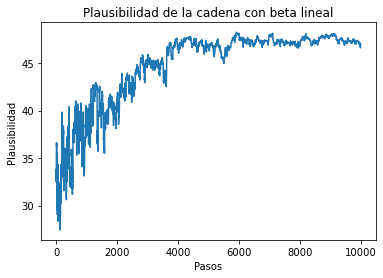

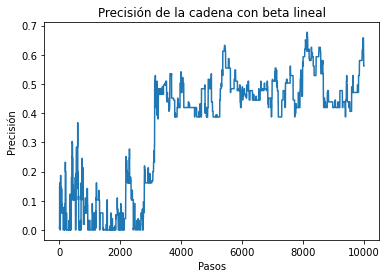

In [35]:
beta = lambda x: 10**(-3) * x
Niter = 10000
beta_lineal, scores_lineal, accuracies_lineal = SADecipher(ciphertext, Niter, beta, plaintext, print_period = 1000)
print(f"Estado de la cadena luego de 10 pasos con beta lineal: {sample_advance}")
print(f"Indices intercambiados: {[i for i in range(len(example_key)) if 'ABCDEFGHIJKLMNOPQRSTUVWXYZ'[i] != sample_advance[i]]}")
graph_scores(scores_lineal, Niter, "Plausibilidad de la cadena con beta lineal")
graph_accuracies(accuracies_lineal, Niter, "Precisión de la cadena con beta lineal")

In [ ]:
beta = lambda x: 10**(-7) * x ** 2
Niter = 20000
beta_quad, scores_quad, accuracies_quad = SADecipher(ciphertext, Niter, beta, plaintext, print_period = 2000)
print(f"Estado de la cadena luego de 10 pasos con beta lineal: {sample_advance}")
print(f"Indices intercambiados: {[i for i in range(len(example_key)) if 'ABCDEFGHIJKLMNOPQRSTUVWXYZ'[i] != sample_advance[i]]}")
graph_scores(scores_quad, Niter, "Plausibilidad de la cadena con beta cuadrático")
graph_accuracies(accuracies_quad, Niter, "Precisión de la cadena con beta cuadrático")

Paso 0
Frase actual: NEFOYD ZIYD KLDHELD GWLIRL ZA HLAYRYI KL GEDSAZNSLIRY LA FYWYILA ZEWLASZIY BELIKSZ WLFYWKY ZJELAAZ RZWKL WLNYRZ LI JEL DE HZKWL AY AALCY Z FYIYFLW LA OSLAY
Plausibilidad: 36.561081878499465


### Test con un texto más largo: Entrada de Roberto Bolaño en Wikipedia

In [ ]:
def read_text(filepath: str):
    '''
    Lee y limpia un archivo de texto
    '''
    with open("bolano_wikipedia.txt", 'r') as f:
        text = f.readlines()
    for i in range(len(text)):
        text[i] = text[i].replace('\n', '')
    
    text = ' '.join(text)
    # Sólo minúsculas
    clean_text = text.casefold()

    # Eliminar tildes
    tilde_dict = {'á':'a', 'é': 'e', 'í': 'i', 'ó':'o', 'ú':'u', 'ñ': 'n'}
    for key, value in tilde_dict.items():
        clean_text = clean_text.replace(key, value)

    # Eliminar caracteres especiales
    clean_text = re.sub(r"[^a-zA-Z ]", "", clean_text)
    clean_text = clean_text.upper()
    return clean_text

test_text = read_text("bolano_wikipedia.txt")
print(test_text)
print(f"Cantidad de caracteres: {len(test_text)}")

In [ ]:
# Generación de una clave aleatoria
real_key = ''.join(random.sample(alphabet[1:], len(alphabet) - 1)) # El primer caracter es un espacio
print(f"Clave : {real_key}")
real_cipher = SimpleSubstitution(real_key)
ciphertext = real_cipher.encipher(test_text, keep_punct = True)
print(ciphertext)

In [ ]:
beta = lambda x: 5*10**(-8) * x ** 2
Niter = 10000
beta2, scores2, accuracies2 = SADecipher(ciphertext, Niter, beta, test_text, print_period = 1000)
graph_scores(scores2, Niter, "Plausibilidad de la cadena con texto largo")
graph_accuracies(accuracies2, Niter, "Precisión de la cadena con texto largo")

## Ataque de trigrama